## Final Project Submission

Please fill out:
* Student name: Stephan Osterburg
* Student pace: full time
* Scheduled project review date/time: 10/29/2018
* Instructor name: Rafael Carrasco 


### Import all needed libraries 

In [2]:
import os
import math
import random

import pandas as pd
import numpy as np
import json

from scipy import stats, linalg

import statsmodels.api as sm
import statsmodels.stats.stattools as sms
from statsmodels.formula.api import ols

from sklearn import metrics
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# set style
sns.set_style('whitegrid')
# overriding font size and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# map visualization
import folium

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 


In [3]:
# import local functions
#
import functions as f

In [4]:
# you can check out the the documentation for the rest of the autoreaload modes
# by apending a question mark to %autoreload, like this:
# %autoreload?
#
%load_ext autoreload
%autoreload 2

#### Description of what can be found in the dataset

+ **ida** notation for a house
+ **date** Date house was sold
+ **price** Price is prediction target
+ **bedrooms** Number of Bedrooms/House
+ **bathrooms** Number of bathrooms/bedrooms
+ **sqft_living** square footage of the home
+ **sqft_lot** square footage of the lot
+ **floors** Total floors (levels) in house
+ **waterfront** House which has a view to a waterfront
+ **view** Has been viewed
+ **condition** How good the condition is ( Overall )
+ **grade** overall grade given to the housing unit, based on King County grading system
+ **sqft_above** square footage of house apart from basement
+ **sqft_basement** square footage of the basement
+ **yr_built** Built Year
+ **yr_renovated** Year when house was renovated
+ **zipcode** zip
+ **lat** Latitude coordinate
+ **long** Longitude coordinate
+ **sqft_living15** Living room area in 2015 (implies-- some renovations) This might or might not have affected the lot size area
+ **sqft_lot15** lotSize area in 2015 (implies-- some renovations)

# Questions:
1. Is location of a house by zipcode/neighborhood an indicator for the house price? 
2. Do have zipcodes (neighborhoods) with the higher housing density an effect on selling price?
3. Does the grade given for a house by the county reflect in the listing price?

## Obtaining Data

In [5]:
# read data and read date correctly
#
dataset = pd.read_csv("kc_house_data.csv", parse_dates = ['date'])

### Collecting basic informations about the data set

In [6]:
dataset.shape

(21597, 21)

In [7]:
dataset.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement            object
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

___

# Scrubbing Data


## Cleaning Data

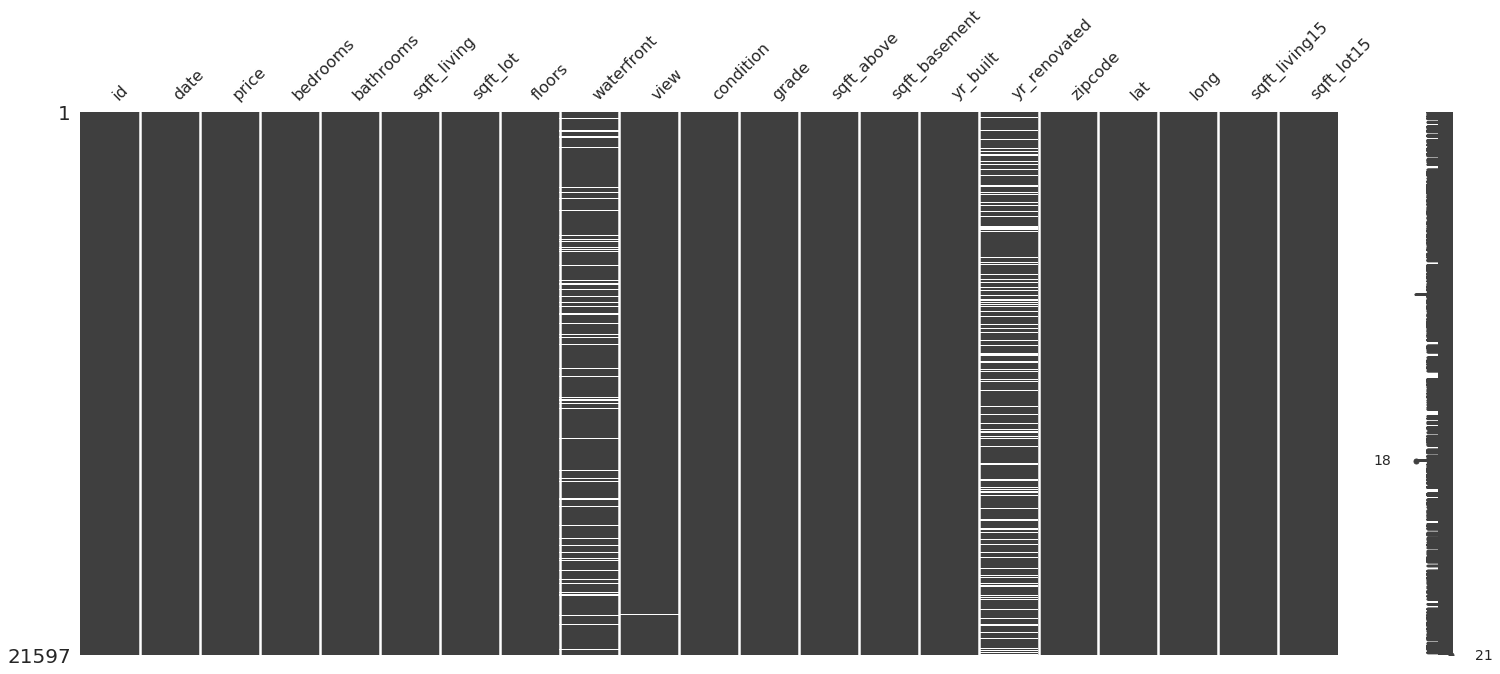

In [8]:
# Display all missing data
#
msno.matrix(dataset);

In [9]:
# Handling Null values for view
#
dataset.view.fillna(0, inplace=True)

In [10]:
# Handling yr_renovated
# - create new column 'is_renovated' and 'yr_since_renovation'
# - if sqft_living15 > sqft_living set renovated
# - drop yr_renovated
#
import datetime
cur_year = datetime.datetime.now().year

def calc_years(row):
    return cur_year - row['yr_renovated'] if row['yr_renovated'] > 0 else 0

def set_renovated(row):
    return 1 if row['yr_since_renovation'] > 0 or row['sqft_living'] != row['sqft_living15'] else 0

# Set yr_renovated to int
dataset.yr_renovated.fillna(0, inplace = True)
# now I can convert yr_renovated to int
dataset.yr_renovated = dataset.yr_renovated.astype('int64')

dataset['yr_since_renovation'] = dataset.apply(calc_years, axis = 1)

# Create category 'is_renovated'
dataset['is_renovated'] = dataset.apply(set_renovated, axis=1)

dataset.drop(columns=['yr_renovated'], inplace=True)

In [11]:
# While are at it, lets convert yr_built to house_age and drop yr_built
#
dataset['house_age'] = cur_year - dataset.yr_built
dataset.drop(columns=['yr_built'], inplace=True)

In [12]:
# What is the percential of NaN in waterfront?
#
print(dataset.waterfront.isnull().sum() / dataset.shape[0])

0.11001527989998611


In [13]:
# Because the percential is about 10% we set the NaN values to zero
#
dataset.waterfront.fillna(0, inplace=True)

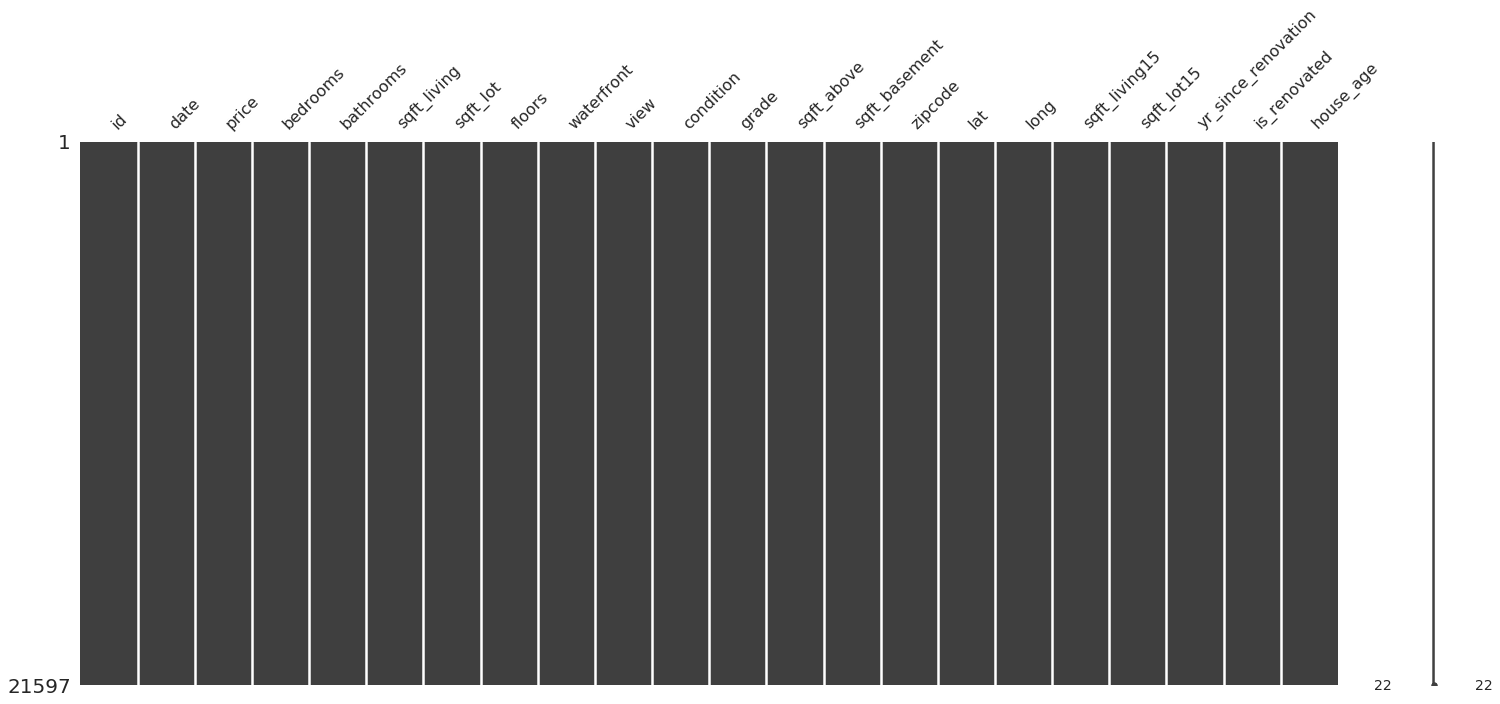

In [14]:
msno.matrix(dataset);

In [15]:
dataset.shape

(21597, 22)

### Cleaning basement feature

In [16]:
# Handling sqft_basement
#
def calc_basement(row):
    """
    Calculate basement sqft based on difference sqft_living and sqft_above
    Deals at the same time with the '?'
    
    :param row: feature (column)
    :return: value (sqft)
    """
    return row['sqft_living'] - row['sqft_above'] if row['sqft_above'] < row['sqft_living']  else 0

dataset.sqft_basement = dataset.apply(calc_basement, axis = 1)

In [17]:
# sort dataset by date and reset index (Do I have a good reason for it? No.)
#
dataset = dataset.sort_values(by = ['date'])
dataset = dataset.reset_index(drop=True)

### Get the big picture

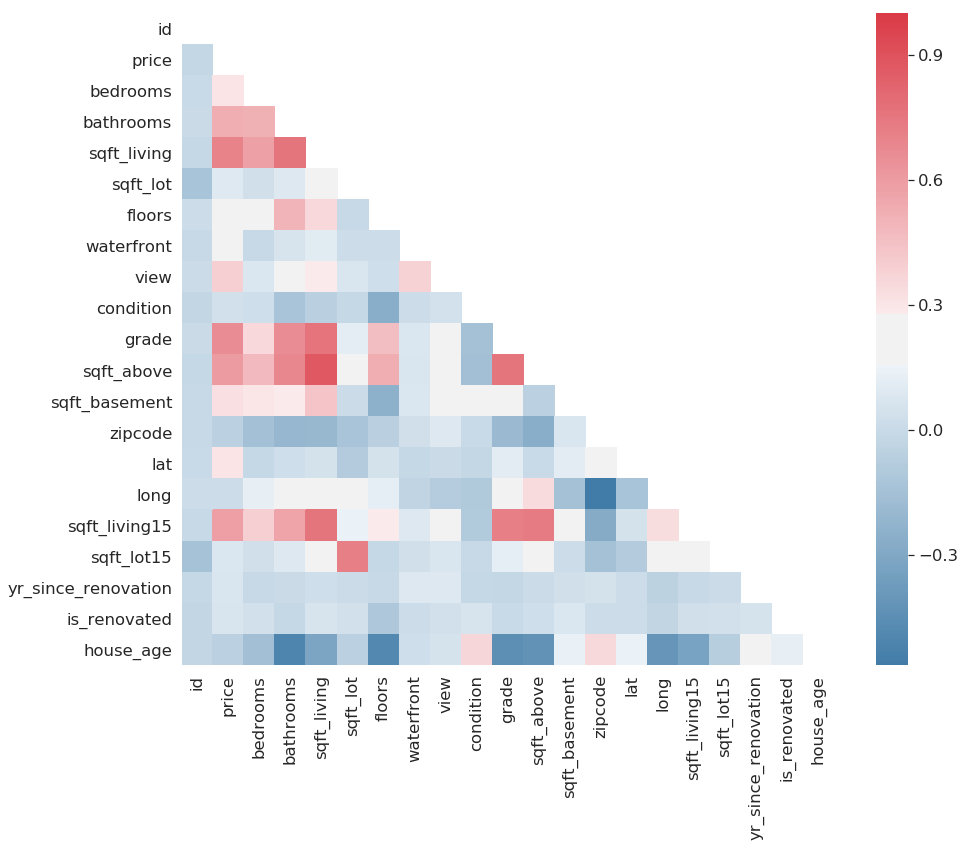

In [18]:
f.display_heatmap(dataset);

Initial observation (based on the darker colours/higher and lower values):
    * In general there are very few strong correlations (around 0.7 and above)
    * price correlates to sqft_living (both), grade and very little to view
    * grade and sqft_above do correlate
    * we can consolidate sqft_living, sqft_living15 and sqft_above

### Investigating Continuos Variables

In [19]:
# 'house_age', 'sqft_basement', 'sqft_above', 'sqft_living15',  'sqft_lot15', 'yr_since_renovation'
#
continous_vars = ['house_age', 'yr_since_renovation', 'sqft_living15',  'sqft_lot15']

___

## Visualize house prices and density by zipcode

Because it's a question want to try to answer, but it's not reflected in the above initial corr plot

In [20]:
# Set zipcode type to string (folium)
dataset['zipcode'] = dataset['zipcode'].astype('str')

# get the mean value across all data points
zipcode_data = dataset.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)

In [21]:
# count number of houses grouped by zipcode
#
dataset['count'] = 1
t = dataset.groupby('zipcode').sum()
t.reset_index(inplace = True)
t = t[['zipcode', 'count']]
zipcode_data = pd.merge(zipcode_data, t, on='zipcode')

# drop count from org dataset
dataset.drop(['count'], axis = 1, inplace = True)

In [22]:
# Get geo data file path
geo_data_file = os.path.join('data', 'king_county_wa_zipcode_area.geojson')

# load GeoJSON
with open(geo_data_file, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
    
tmp = geo_data

# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

11783863

In [23]:
# Get the top 5 zipcode by price
#
zipcode_data.nlargest(5, 'price')

,zipcode,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,is_renovated,house_age,count
24,98039,3.755708e+09,2.161300e+06,4.060000,3.200000,3800.900000,17403.560000,1.560000,0.020000,0.440000,...,3290.900000,510.000000,47.625840,-122.233540,3132.200000,17291.100000,4.520000,0.960000,45.480000,50
3,98004,4.394237e+09,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003155,0.305994,...,2419.842271,489.179811,47.616183,-122.205189,2674.700315,12805.022082,1.574132,0.933754,46.529968,317
25,98040,4.199323e+09,1.194874e+06,4.028369,2.716312,3106.833333,13704.464539,1.505319,0.039007,0.765957,...,2474.329787,632.503546,47.559846,-122.225592,2898.744681,12801.283688,2.187943,0.950355,46.528369,282
48,98112,4.826282e+09,1.096239e+06,3.509294,2.373606,2498.743494,4990.431227,1.806691,0.000000,0.148699,...,2005.695167,493.048327,47.629619,-122.297866,2280.078067,4898.159851,1.431227,0.910781,73.550186,269
41,98102,4.102040e+09,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,1.990385,0.000000,0.153846,...,1752.442308,398.605769,47.634591,-122.322250,1954.471154,3303.500000,1.038462,0.913462,65.836538,104


___

### Get a gerneral overview via scatter plot

In [24]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,is_renovated,house_age
0,2202500290,2014-05-02,435000.0,4,1.0,1450,8800,1.0,0.0,0.0,...,1450,0,98006,47.5746,-122.135,1260,8942,0,1,64
1,7853361370,2014-05-02,555000.0,4,2.5,3310,6500,2.0,0.0,0.0,...,3310,0,98065,47.5150,-121.870,2380,5000,0,1,6
2,7197300105,2014-05-02,550000.0,4,2.5,1940,10500,1.0,0.0,0.0,...,1140,800,98052,47.6830,-122.114,2200,10500,0,1,42
3,3438501320,2014-05-02,295000.0,2,2.5,1630,1368,2.0,0.0,0.0,...,1280,350,98106,47.5489,-122.363,1590,2306,0,1,9
4,472000620,2014-05-02,790000.0,3,2.5,2600,4750,1.0,0.0,0.0,...,1700,900,98117,47.6833,-122.400,2380,4750,0,1,67


In [25]:
dataset.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_since_renovation', 'is_renovated',
       'house_age'],
      dtype='object')

In [26]:
dataset['zipcode'] = dataset['zipcode'].astype(int)

In [27]:
cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
        'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 
        'yr_since_renovation', 'is_renovated', 'house_age', 'view', 'zipcode']

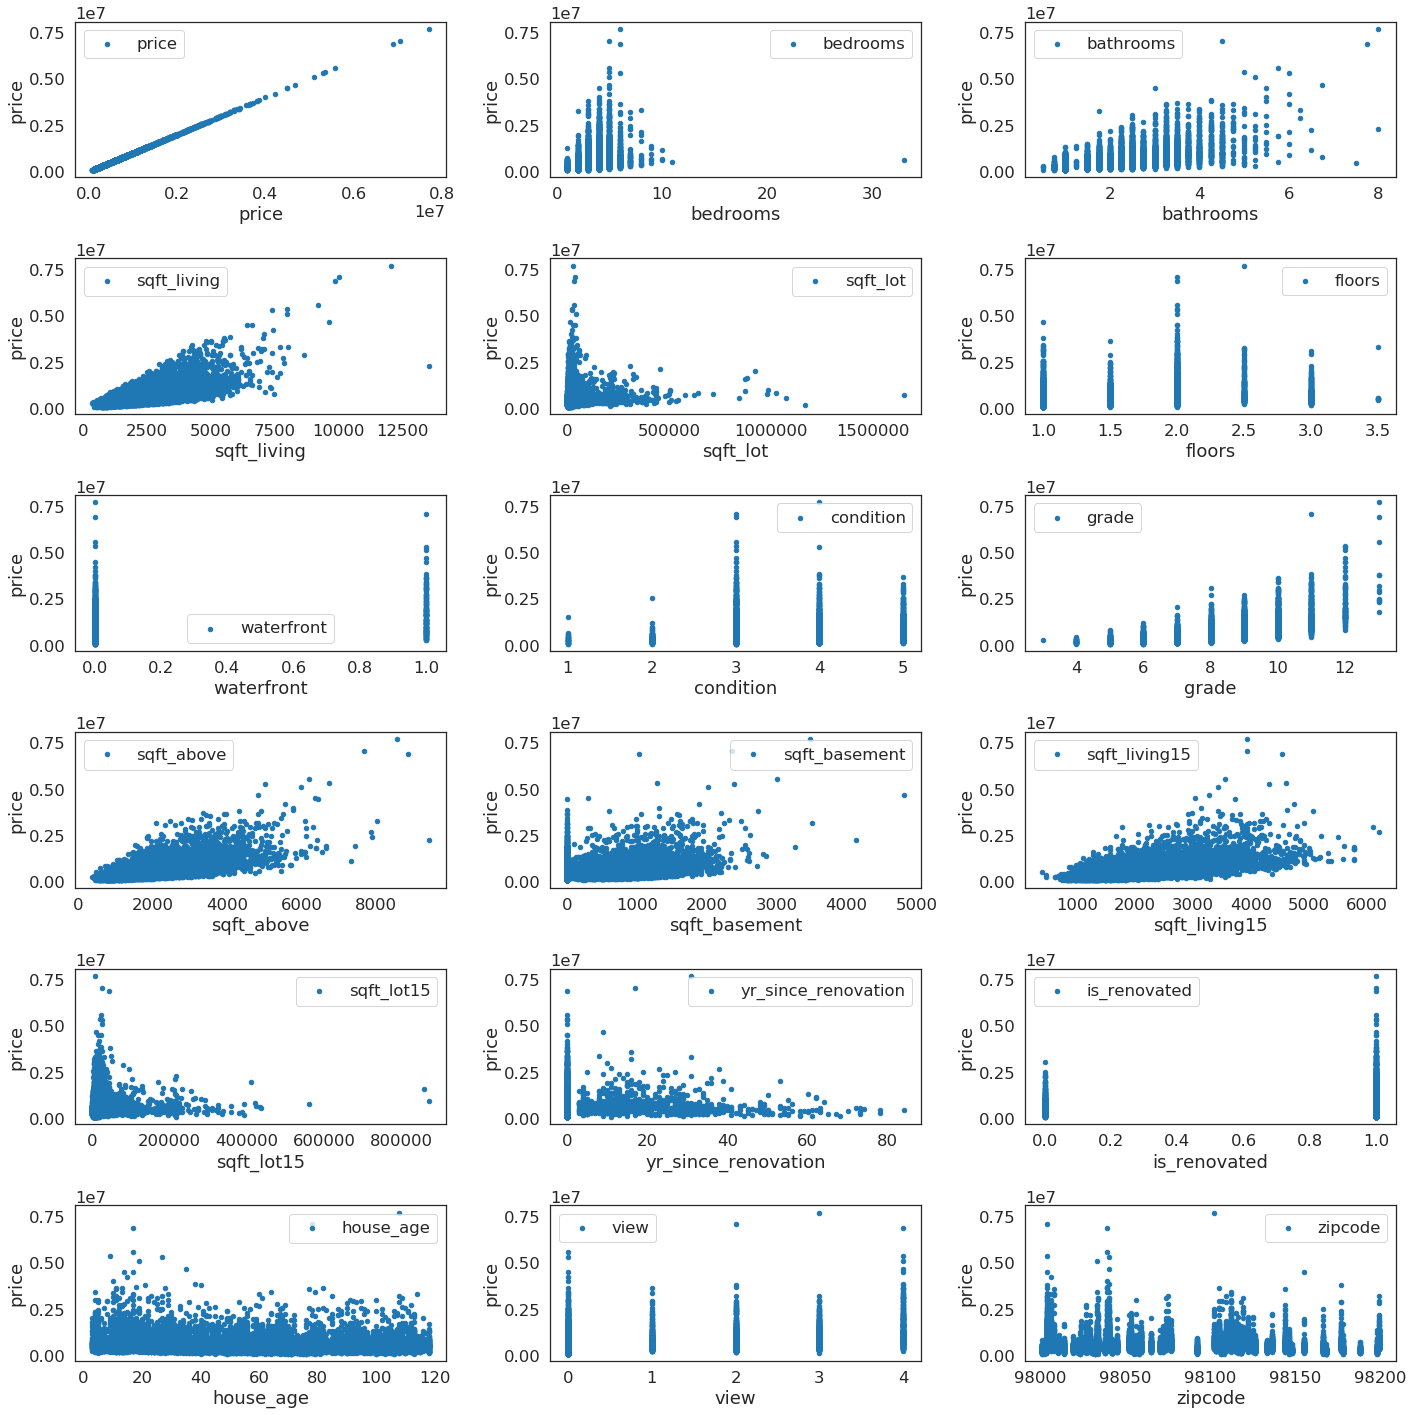

In [28]:
ncol = 3 # pick one dimension
nrow = math.floor((len(cols)+ ncol-1) / ncol) # make sure enough subplots
fig, axarr = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20)) # create the axes

for i in range(len(cols)): # go over a linear list of data
    ix = np.unravel_index(i, axarr.shape) # compute an appropriate index (1d or 2d)

    name = cols[i]
    dataset.plot(kind='scatter', x=name, y='price', ax=axarr[ix], label=name) 

plt.tight_layout()
plt.show();

**Notes:** 
    * Cross referencing on trulia, there are houses with a high sqft_living15 as well a price at $24,000,000
    * And as it turns out the number of bathrooms can be 8 or even 9, and it looks like that it might have some effect on the price
    * But 30+ bedrooms is an outlier, they as well looks like can have some effect on the price 
    * How does age (yr_built) and sqft_living coerlate?
    * It looks like that zipcodes are coerlated to price

#### Initial Thoughts

    * there are outliers with a very high price in the lower part of sqft_living
    * looks like that there are concentration of houses in or around specific zipcodes

### Relational plots
Visualize the effect grade and condition have on price/sqft_living15

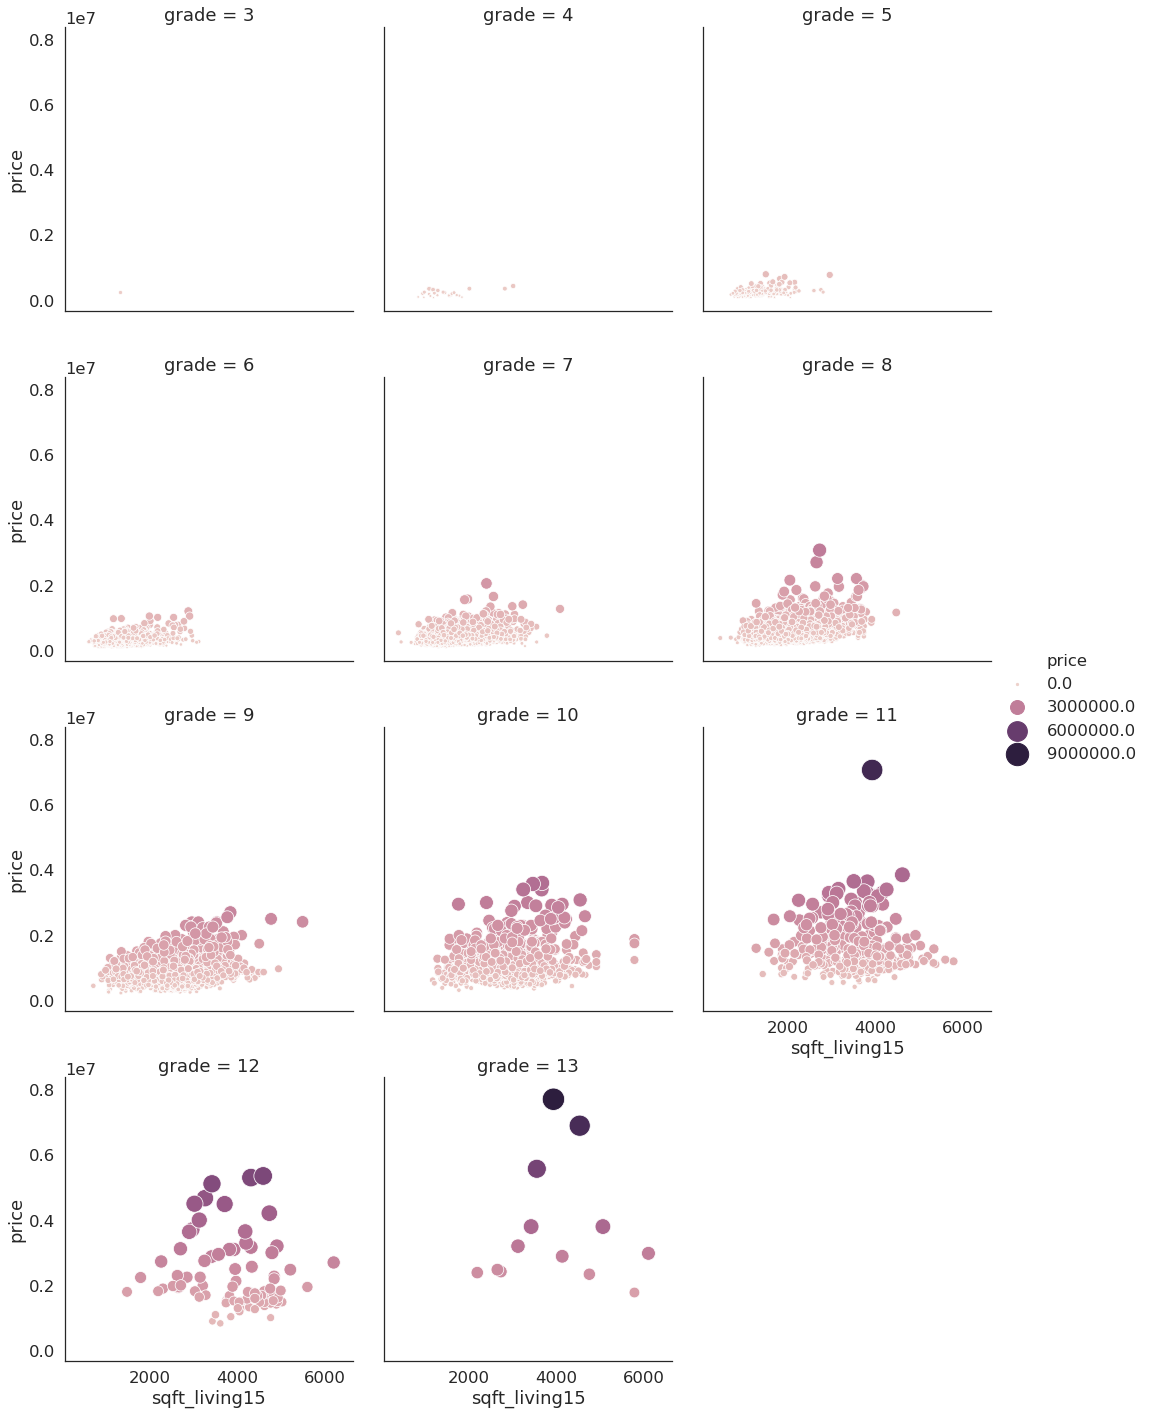

In [29]:
sns.relplot(x="sqft_living15", y="price", hue="price", col="grade", 
            size="price", sizes=(5, 500), col_wrap=3, data=dataset);

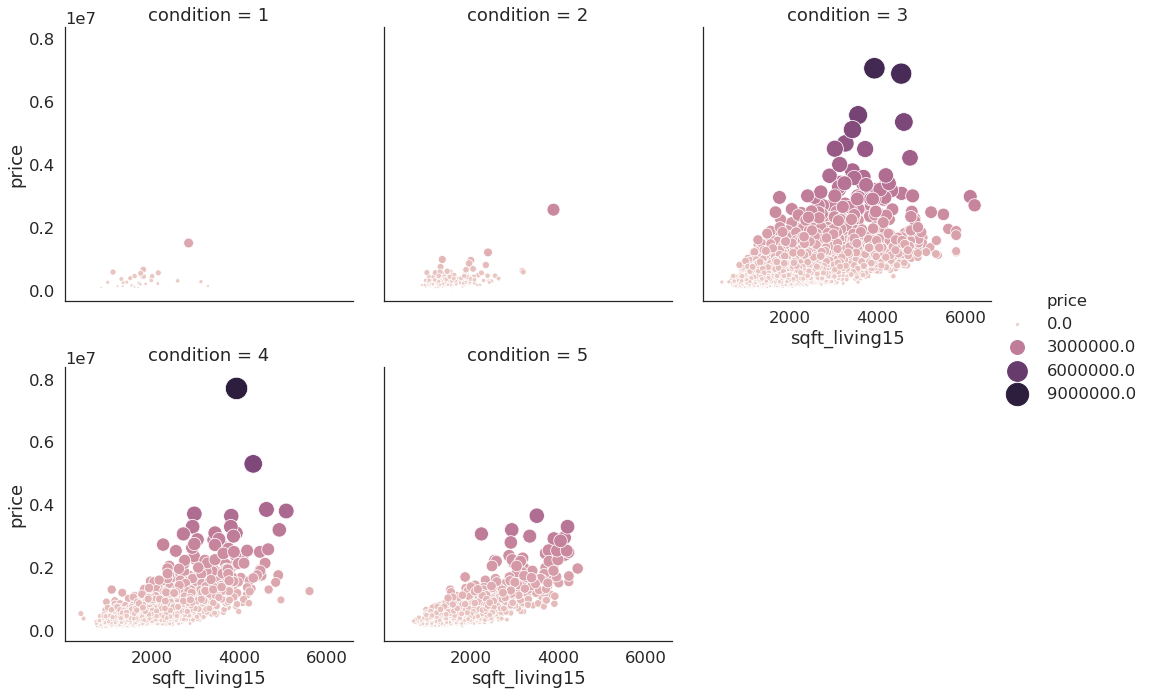

In [30]:
sns.relplot(x="sqft_living15", y="price", hue="price", col="condition",
            size="price", sizes=(5, 500), col_wrap=3, data=dataset);

___

### Categorize Data

In [31]:
dataset['condition'] = dataset['condition'].astype('category', ordered = True)
dataset['waterfront'] = dataset['waterfront'].astype('category', ordered = True)
dataset['is_renovated'] = dataset['is_renovated'].astype('category', ordered = False)
dataset['view'] = dataset['view'].astype('category', ordered = False)

# Create category 'has_basement'
dataset['has_basement'] = dataset.sqft_basement.apply(lambda x: 1 if x > 0 else 0)
dataset['has_basement'] = dataset.has_basement.astype('category', ordered = False)

In [32]:
# Set dummies (we may want to add zipcode as well)
cat_columns = ['floors', 'view', 'condition', 'waterfront', 'is_renovated', 'has_basement']

for col in cat_columns:
    dummies = pd.get_dummies(dataset[col])
    dummies = dummies.add_prefix("{}_".format(col))
    
    dataset.drop(col, axis=1, inplace=True)
    dataset = dataset.join(dummies)

In [33]:
# replace the '.' in the column name
for col in dataset.columns:
    if col.find('.') != -1: 
        dataset.rename(columns={col: col.replace('.', '_')}, inplace=True)

In [34]:
# dropping id and date
dataset.drop(['id', 'date'], axis = 1, inplace = True)

In [35]:
dataset.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,zipcode,lat,...,condition_2,condition_3,condition_4,condition_5,waterfront_0_0,waterfront_1_0,is_renovated_0,is_renovated_1,has_basement_0,has_basement_1
0,435000.0,4,1.0,1450,8800,7,1450,0,98006,47.5746,...,0,0,1,0,1,0,0,1,1,0
1,555000.0,4,2.5,3310,6500,8,3310,0,98065,47.5150,...,0,1,0,0,1,0,0,1,1,0
2,550000.0,4,2.5,1940,10500,7,1140,800,98052,47.6830,...,0,0,1,0,1,0,0,1,0,1
3,295000.0,2,2.5,1630,1368,7,1280,350,98106,47.5489,...,0,1,0,0,1,0,0,1,0,1
4,790000.0,3,2.5,2600,4750,9,1700,900,98117,47.6833,...,0,0,1,0,1,0,0,1,0,1


## Investigating outliers

In [36]:
dataset.sqft_lot15.value_counts(bins=10)

(-219.55, 87705.9]      21201
(87705.9, 174760.8]       196
(174760.8, 261815.7]      165
(261815.7, 348870.6]       21
(348870.6, 435925.5]       10
(784145.1, 871200.0]        2
(522980.4, 610035.3]        1
(435925.5, 522980.4]        1
(697090.2, 784145.1]        0
(610035.3, 697090.2]        0
Name: sqft_lot15, dtype: int64

In [37]:
dataset.bathrooms.value_counts(bins=10)

(2.0, 2.75]      8609
(1.25, 2.0]      6423
(0.491, 1.25]    3935
(2.75, 3.5]      2073
(3.5, 4.25]       370
(4.25, 5.0]       144
(5.0, 5.75]        27
(5.75, 6.5]        10
(7.25, 8.0]         4
(6.5, 7.25]         2
Name: bathrooms, dtype: int64

In [38]:
dataset.bedrooms.value_counts(bins=10)

(0.967, 4.2]    19662
(4.2, 7.4]       1911
(7.4, 10.6]        22
(29.8, 33.0]        1
(10.6, 13.8]        1
(26.6, 29.8]        0
(23.4, 26.6]        0
(20.2, 23.4]        0
(17.0, 20.2]        0
(13.8, 17.0]        0
Name: bedrooms, dtype: int64

In [ ]:
dataset.price.value_counts(bins=10)

* But as mentioned above, regarding to trulia most os them seem legit. With the exception of negative lot sqft.

## Normalize dataset

In [42]:
# Using MinMax
#
minmax_df = dataset[['house_age', 'yr_since_renovation', 'zipcode']]

scaler = preprocessing.MinMaxScaler()
minmax_scaled_df = scaler.fit_transform(minmax_df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df, columns=['house_age', 'yr_since_renovation', 'zipcode'])

In [43]:
# Using Robust for price and sqft
#
robust_df = dataset[['price', 'sqft_above', 'sqft_living15', 'sqft_lot15']]

scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(robust_df)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=['price', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

## Create new dataset with selected features

In [44]:
dataset_ols = pd.concat([dataset[['grade', 'bedrooms', 'bathrooms', 'condition_3', 'condition_4', 
                                  'condition_5']], minmax_scaled_df, robust_scaled_df], axis=1)

In [45]:
dataset_ols.head()

,grade,bedrooms,bathrooms,condition_3,condition_4,condition_5,house_age,yr_since_renovation,zipcode,price,sqft_above,sqft_living15,sqft_lot15
0,7,4,1.0,0,1,0,0.530435,0.0,0.025253,-0.046440,-0.107843,-0.666667,0.265302
1,8,4,2.5,1,0,0,0.026087,0.0,0.323232,0.325077,1.715686,0.620690,-0.525788
2,7,4,2.5,0,1,0,0.339130,0.0,0.257576,0.309598,-0.411765,0.413793,0.577965
3,7,2,2.5,1,0,0,0.052174,0.0,0.530303,-0.479876,-0.274510,-0.287356,-1.066426
4,9,3,2.5,0,1,0,0.556522,0.0,0.585859,1.052632,0.137255,0.620690,-0.575958


___

## Regression Model

In [46]:
ols_results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)']]

In [47]:
features = ['grade', 'bedrooms', 'bathrooms', 'house_age', 'yr_since_renovation', 'sqft_above',
            'sqft_living15', 'sqft_lot15', 'zipcode', 'condition_3', 'condition_4', 'condition_5']

In [48]:
def run_ols_regression(store_results, data, target, feature, show_plots=False):
    """
    Run ols model, prints model summary, displays plot_regress_exog and qqplot
    
    :param data: dataset
    :param target: target feature name
    :param feature: feature name
    :return:
    """
    
    formula = target + '~' + feature
    model = ols(formula=formula, data=data).fit()

    df = pd.DataFrame({feature: [data[feature].min(), data[feature].max()]})
    pred = model.predict(df)

    if show_plots:
        print('Regression Analysis and Diagnostics for formula: ', formula)
        print('\n')

        fig = plt.figure(figsize=(16, 8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show();

        residuals = model.resid
        fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
        fig.show();
    
    # append all information to results
    store_results.append([feature, model.rsquared, model.params[0], model.params[0],
                        model.pvalues[1], sms.jarque_bera(model.resid)[0]])


In [49]:
for f in features:
    run_ols_regression(ols_results, dataset, 'price', f)

In [50]:
pd.DataFrame(ols_results)

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,grade,0.446158,-1.06142e+06,-1.06142e+06,0,2.0439e+06
2,bedrooms,0.0953497,127200,127200,0,1.1951e+06
3,bathrooms,0.276577,8712.65,8712.65,0,882736
4,house_age,0.00291096,572010,572010,2.11758e-15,1.14251e+06
5,yr_since_renovation,0.00522009,536226,536226,2.1355e-26,1.0935e+06
6,sqft_above,0.36647,59757.1,59757.1,0,728366
7,sqft_living15,0.342507,-83028.5,-83028.5,0,1.91058e+06
8,sqft_lot15,0.00686328,526060,526060,3.30159e-34,1.14233e+06
9,zipcode,0.00285182,3.64965e+07,3.64965e+07,4.0579e-15,1.12339e+06


We shall drop 'yr_since_renovation', 'sqft_above', 'bedrooms', 'condition_3', 'condition_4' 
from the feature list

## Regression Model Validation

In [51]:
y = dataset_ols['price']
X = dataset_ols.drop(['price', 'yr_since_renovation', 'sqft_above', 'bedrooms', 
                      'condition_3', 'condition_4'], axis=1)

In [52]:
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4254.
Date:                Wed, 31 Oct 2018   Prob (F-statistic):               0.00
Time:                        07:27:17   Log-Likelihood:                -24064.
No. Observations:               21597   AIC:                         4.814e+04
Df Residuals:                   21589   BIC:                         4.821e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.1866      0.052    -99.305      0.000      -5.289      -5.084
grade             0.5201      0.007     74.487      0.000       0.506       0.534
bathrooms         0.3704      0.009     39.237      0.000       0.352       0.389
condition_5       0.1432      0.019      7.400      0.000       0.105       0.181
house_age         1.5917      0.025     63.472      0.000       1.543       1.641
zipcode           0.0929      0.020      4.548      0.000       0.053       0.133
sqft_living15     0.2688      0.010     28.105      0.000       0.250       0.288
sqft_lot15       -0.0019      0.001     -2.035      0.042      -0.004   -7.06e-05
==============================================================================
Omnibus:                    20457.904   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2554549.525
Skew:                           4.216   Prob(JB):                         0.00
Kurtosis:                      55.609   Cond. No.                         89.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [54]:
# Fitting the model to the training data
linreg = LinearRegression().fit(X_train, y_train)

# Calc preditors on the train and test set
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [55]:
# Calc residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [56]:
# Calc MSE (Mean Squared Error)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.5059053081401828
Test Mean Squarred Error: 0.6972593148788161


### Residual Histogram

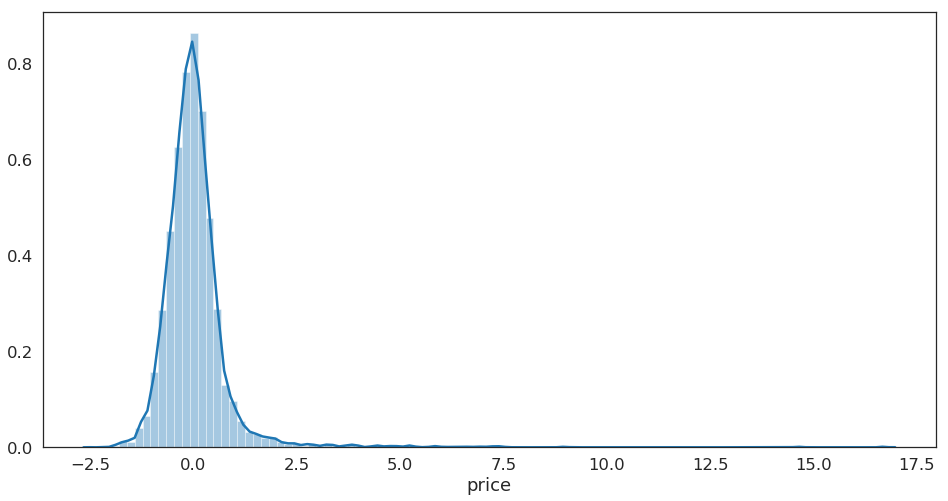

In [57]:
fig = plt.figure(figsize=(16, 8))
sns.distplot(y_test - y_hat_test, bins=100);
# sns.distplot(test_residuals, bins=50)

## Cross Validation

90


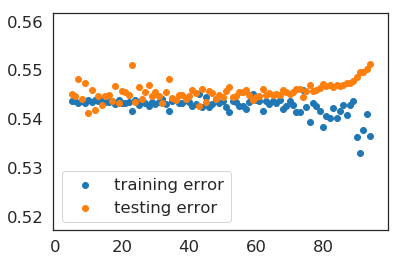

In [58]:
train_error = []
test_error = []

for t in range(5, 95):
    train_temp = []
    test_temp = []
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t/100)
        linreg.fit(X_train, y_train)

        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)

        train_temp.append(mean_squared_error(y_train, y_hat_train))
        test_temp.append(mean_squared_error(y_test, y_hat_test))
    
    # save average train/test errors
    train_error.append(np.mean(train_temp))
    test_error.append(np.mean(test_temp))

print(len(train_error))
plt.scatter(range(5, 95), train_error, label='training error')
plt.scatter(range(5, 95), test_error, label='testing error')

plt.legend()
plt.show()

In [59]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [60]:
print(cv_5_results, cv_10_results, cv_20_results)

-0.5459745256605009 -0.5454349023542565 -0.5448528495186913


### Regression Evaluation

In [61]:
print('MAE: ', metrics.mean_absolute_error(y_test, y_hat_test))
print('MSE: ', metrics.mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))

MAE:  0.49829240353830095
MSE:  0.5571307977042553
RMSE: 0.7464119490631533


---
## Answers
1. Zipcode (neighborhood) can be an indicator for house prices.
2. Housing density not so much
3. And in regards to the grade, inconclusive.